

# 09 - Full Shift Adaptation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IvanNece/Detection-of-Anomalies-with-Localization/blob/main/notebooks/09_full_shift_adaptation.ipynb)

This notebook implements the full shift adaptation approach, where the model is trained on the train-shifted dataset, threshold is computed on the val-shifted dataset and evaluated on the test-shifted dataset.

**Metrics computed:**
- Image-level: AUROC, AUPRC, F1, Accuracy, Precision, Recall
- Pixel-level: Pixel AUROC, PRO (Per-Region Overlap)


## 1. Setup - Mount Drive & Clone Repository

In [1]:
from google.colab import drive
from pathlib import Path
import os
import sys

drive.mount('/content/drive')

repo_dir = '/content/Detection-of-Anomalies-with-Localization'

# Remove if exists
if os.path.exists(repo_dir):
    print("Removing existing repository...")
    !rm -rf {repo_dir}

# Clone from main branch
!git clone   https://github.com/IvanNece/Detection-of-Anomalies-with-Localization.git {repo_dir}

# Setup paths
PROJECT_ROOT = Path(repo_dir)

# Dataset locations (both clean and shifted)
CLEAN_DATASET_PATH = Path('/content/drive/MyDrive/mvtec_ad')
SHIFTED_DATASET_PATH = Path('/content/drive/MyDrive/mvtec_shifted')

# Output directories
MODELS_DIR = PROJECT_ROOT / 'outputs' / 'models'
RESULTS_DIR = PROJECT_ROOT / 'outputs' / 'results'
THRESHOLDS_DIR = PROJECT_ROOT / 'outputs' / 'thresholds'
VIZ_DIR = PROJECT_ROOT / 'outputs' / 'visualizations' / 'shifted_full_adaptation'

MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
THRESHOLDS_DIR.mkdir(parents=True, exist_ok=True)
VIZ_DIR.mkdir(parents=True, exist_ok=True)

# Verify datasets exist
if not CLEAN_DATASET_PATH.exists():
    raise FileNotFoundError(
        f"Clean dataset not found at {CLEAN_DATASET_PATH}\n"
        f"Please ensure mvtec_ad folder is in your Google Drive."
    )

if not SHIFTED_DATASET_PATH.exists():
    raise FileNotFoundError(
        f"Shifted dataset not found at {SHIFTED_DATASET_PATH}\n"
        f"Please run notebook 03_domain_shift_generation.ipynb first."
    )

# Add project root to Python path
sys.path.insert(0, str(PROJECT_ROOT))

Mounted at /content/drive
Cloning into '/content/Detection-of-Anomalies-with-Localization'...
remote: Enumerating objects: 1419, done.
remote: Counting objects: 100% (293/293), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 1419 (delta 108), reused 181 (delta 61), pack-reused 1126 (from 3)
Receiving objects: 100% (1419/1419), 438.72 MiB | 35.55 MiB/s, done.
Resolving deltas: 100% (726/726), done.
Error downloading object: outputs/models/padim_carpet_clean.pt (c5f08e6): Smudge error: Error downloading outputs/models/padim_carpet_clean.pt (c5f08e6a66aaad9c354e37e3dfcdc363d0fc17764922d97746ee0ff947df2768): batch response: This repository exceeded its LFS budget. The account responsible for the budget should increase it to restore access.

Errors logged to /content/Detection-of-Anomalies-with-Localization/.git/lfs/logs/20260107T103923.155757262.log
Use `git lfs logs last` to view the log.
error: external filter 'git-lfs filter-process' failed
fatal: outputs/models/p

## 2. Install Dependencies

In [2]:
!pip install faiss-cpu --quiet
!pip install anomalib --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 113.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.8/851.8 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 113.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 124.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.5/760.5 kB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 69.2 MB/s eta 0:00:00


## 3. Import Libraries

In [3]:

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
import warnings
from tqdm import tqdm
from datetime import datetime

# Project imports
from src.utils.reproducibility import set_seed
from src.utils.config import load_config
from src.utils.paths import ProjectPaths
from src.data.splitter import load_splits
from src.data.dataset import MVTecDataset
from src.data.transforms import get_clean_transforms
from src.models.patchcore import PatchCore
from src.models.padim_wrapper import PadimWrapper
from src.utils.utils import custom_collate_fn

# Metrics imports
from src.metrics import (
    calibrate_threshold,
    calibrate_threshold_with_curve,
    ThresholdCalibrator,
    compute_image_metrics,
    compute_pixel_metrics,
    compute_roc_curve,
    compute_pr_curve,
    compute_confusion_matrix,
    aggregate_metrics,
    aggregate_pixel_metrics
)

# Set random seed for reproducibility
set_seed(42)

# Load configuration
config = load_config(PROJECT_ROOT / 'configs' / 'experiment_config.yaml')
paths = ProjectPaths(PROJECT_ROOT)

# Classes to process
CLASSES = config.dataset.classes  # ['hazelnut', 'carpet', 'zipper']

# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print("=" * 70)
print("PHASE 7: FULL SHIFT ADAPTATION")
print("=" * 70)
print(f"Using device: {DEVICE}")
print(f"Classes: {CLASSES}")
print(f"Coreset ratio: {config.patchcore.coreset_sampling_ratio}")
print(f"Batch size: 8")
print("=" * 70)

Loaded configuration from /content/Detection-of-Anomalies-with-Localization/configs/experiment_config.yaml
PHASE 7: FULL SHIFT ADAPTATION
Using device: cuda
Classes: ['hazelnut', 'carpet', 'zipper']
Coreset ratio: 0.05
Batch size: 8


## 4. Load Shifted Splits

In [4]:
# Load shifted splits
SHIFTED_SPLITS_PATH = paths.get_split_path('shifted')
shifted_splits = load_splits(SHIFTED_SPLITS_PATH)

# Print split statistics
print("\nShifted Split Statistics:")
print("-" * 70)
for class_name in CLASSES:
    train_n = len(shifted_splits[class_name]['train']['images'])
    val_n = len(shifted_splits[class_name]['val']['images'])
    test_n = len(shifted_splits[class_name]['test']['images'])

    val_normal = sum(1 for l in shifted_splits[class_name]['val']['labels'] if l == 0)
    val_anom = sum(1 for l in shifted_splits[class_name]['val']['labels'] if l == 1)
    test_normal = sum(1 for l in shifted_splits[class_name]['test']['labels'] if l == 0)
    test_anom = sum(1 for l in shifted_splits[class_name]['test']['labels'] if l == 1)

    print(f"{class_name}:")
    print(f"  Train-shift: {train_n} (all normal)")
    print(f"  Val-shift: {val_n} ({val_normal} normal, {val_anom} anomalous)")
    print(f"  Test-shift: {test_n} ({test_normal} normal, {test_anom} anomalous)")
print("-" * 70)


Shifted Split Statistics:
----------------------------------------------------------------------
hazelnut:
  Train-shift: 312 (all normal)
  Val-shift: 100 (79 normal, 21 anomalous)
  Test-shift: 89 (40 normal, 49 anomalous)
carpet:
  Train-shift: 224 (all normal)
  Val-shift: 82 (56 normal, 26 anomalous)
  Test-shift: 91 (28 normal, 63 anomalous)
zipper:
  Train-shift: 192 (all normal)
  Val-shift: 83 (48 normal, 35 anomalous)
  Test-shift: 116 (32 normal, 84 anomalous)
----------------------------------------------------------------------


## 5. Prepare Data Transforms and Loaders

In [5]:
# Create transform for shifted data (same as clean - no additional augmentation)
# The domain shift is already "baked" into the shifted dataset images
transform = get_clean_transforms(
    image_size=config.dataset.image_size,
    normalize_mean=config.dataset.normalize.mean,
    normalize_std=config.dataset.normalize.std
)

---
# PART A: PATCHCORE - FULL SHIFT ADAPTATION
---

## 6. Re-train PatchCore on Train-Shift

In [6]:
# Hyperparameters
CORESET_RATIO = config.patchcore.coreset_sampling_ratio
BATCH_SIZE = 8
NUM_WORKERS = 0  # Set to 0 for Colab

print("\n" + "="*70)
print("PATCHCORE - TRAINING ON TRAIN-SHIFT")
print("="*70)
print(f"Coreset ratio: {CORESET_RATIO*100:.1f}%")
print(f"Batch size: {BATCH_SIZE}")
print(f"Num workers: {NUM_WORKERS}")
print(f"Image size: {config.dataset.image_size}")
print(f"Backbone layers: {config.patchcore.layers}")
print(f"Patch size: {config.patchcore.patch_size}")
print(f"N neighbors: {config.patchcore.n_neighbors}")
print("="*70)


PATCHCORE - TRAINING ON TRAIN-SHIFT
Coreset ratio: 5.0%
Batch size: 8
Num workers: 0
Image size: 224
Backbone layers: ['layer2', 'layer3']
Patch size: 3
N neighbors: 9


In [7]:
patchcore_models_shift = {}
patchcore_training_stats_shift = {}

for class_name in CLASSES:
    print("\n" + "=" * 70)
    print(f"Training PatchCore on TRAIN-SHIFT: {class_name.upper()}")
    print("=" * 70)

    # Check if model files already exist
    model_file = paths.MODELS / f'patchcore_{class_name}_shift.npy'
    config_file = paths.MODELS / f'patchcore_{class_name}_shift_config.pth'

    if model_file.exists() and config_file.exists():
        print(f"\n✓ Model files found! Loading existing model...")
        print(f"  • {model_file.name}")
        print(f"  • {config_file.name}")

        # Load existing model
        model = PatchCore(
            backbone_layers=config.patchcore.layers,
            patch_size=config.patchcore.patch_size,
            coreset_ratio=CORESET_RATIO,
            n_neighbors=config.patchcore.n_neighbors,
            device=DEVICE
        )
        model.load(paths.MODELS, class_name, domain='shift')

        # Load training stats from config file
        checkpoint = torch.load(config_file, map_location=DEVICE)
        patchcore_training_stats_shift[class_name] = {
            'n_train_images': checkpoint.get('n_train_images', 'N/A'),
            'memory_bank_size': len(model.memory_bank),
            'training_time_seconds': checkpoint.get('training_time_seconds', 'N/A'),
            'spatial_dims': model.spatial_dims
        }

        print(f"  Memory bank size: {len(model.memory_bank)}")
        print(f"  Spatial dims: {model.spatial_dims}")
        print("  [SKIPPED TRAINING - Using cached model]")

    else:
        print(f"\n⚠ Model files not found. Starting training from scratch...")

        # Create train dataset (only normal images from shifted data)
        train_split = shifted_splits[class_name]['train']
        train_dataset = MVTecDataset.from_split(
            train_split,
            transform=transform,
            phase='train'
        )

        train_loader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=False,
            collate_fn=custom_collate_fn
        )

        print(f"\nTrain-shift dataset: {len(train_dataset)} images")

        # Initialize PatchCore
        model = PatchCore(
            backbone_layers=config.patchcore.layers,
            patch_size=config.patchcore.patch_size,
            coreset_ratio=CORESET_RATIO,
            n_neighbors=config.patchcore.n_neighbors,
            device=DEVICE
        )

        # Fit model
        start_time = time.time()
        model.fit(train_loader, apply_coreset=True)
        training_time = time.time() - start_time

        # Save model with 'shift' domain tag
        model.save(paths.MODELS, class_name, domain='shift')

        # Store statistics
        patchcore_training_stats_shift[class_name] = {
            'n_train_images': len(train_dataset),
            'memory_bank_size': len(model.memory_bank),
            'training_time_seconds': training_time,
            'spatial_dims': model.spatial_dims
        }

        print(f"\nCompleted {class_name.upper()}:")
        print(f"  Memory bank size: {len(model.memory_bank)}")
        print(f"  Training time: {training_time:.2f}s")
        print(f"  Spatial dims: {model.spatial_dims}")

    # Store model in dictionary
    patchcore_models_shift[class_name] = model

print("\n" + "=" * 70)
print("✓ All PatchCore models ready!")
print("=" * 70)


Training PatchCore on TRAIN-SHIFT: HAZELNUT

⚠ Model files not found. Starting training from scratch...

Train-shift dataset: 312 images
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s]
Extracting features: 100%|██████████| 39/39 [02:13<00:00,  3.42s/it]



Completed HAZELNUT:
  Memory bank size: 12230
  Training time: 2097.98s
  Spatial dims: (28, 28)

Training PatchCore on TRAIN-SHIFT: CARPET

⚠ Model files not found. Starting training from scratch...

Train-shift dataset: 224 images


Extracting features: 100%|██████████| 28/28 [01:31<00:00,  3.26s/it]



Completed CARPET:
  Memory bank size: 8780
  Training time: 1123.50s
  Spatial dims: (28, 28)

Training PatchCore on TRAIN-SHIFT: ZIPPER

⚠ Model files not found. Starting training from scratch...

Train-shift dataset: 192 images


Extracting features: 100%|██████████| 24/24 [01:16<00:00,  3.18s/it]



Completed ZIPPER:
  Memory bank size: 7526
  Training time: 829.32s
  Spatial dims: (28, 28)

✓ All PatchCore models ready!


## 7. PatchCore - Predict on Val-Shift for Threshold Calibration

In [8]:
print("\n" + "="*70)
print("PATCHCORE - PREDICTING ON VAL-SHIFT")
print("="*70)

patchcore_val_predictions_shift = {}

for class_name in CLASSES:
    print(f"\nProcessing {class_name.upper()}...")

    model = patchcore_models_shift[class_name]

    # Load val-shift data
    val_split = shifted_splits[class_name]['val']
    val_dataset = MVTecDataset.from_split(
        val_split,
        transform=transform,
        phase='val'
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=False,
        collate_fn=custom_collate_fn
    )

    # Predict
    all_scores = []
    all_labels = []

    with torch.no_grad():
        for images, masks, labels, paths in tqdm(val_loader, desc=f"Val-shift {class_name}"):
            images = images.to(DEVICE)
            scores, _ = model.predict(images, return_heatmaps=True)
            all_scores.extend(scores)
            all_labels.extend(labels.numpy())

    patchcore_val_predictions_shift[class_name] = {
        'scores': all_scores,
        'labels': all_labels
    }

    print(f"  Val-shift predictions: {len(all_scores)} samples")
    print(f"  Normal: {sum(1 for l in all_labels if l == 0)}, Anomalous: {sum(1 for l in all_labels if l == 1)}")

print("\n✓ PatchCore val-shift predictions complete!")


PATCHCORE - PREDICTING ON VAL-SHIFT

Processing HAZELNUT...


Val-shift hazelnut: 100%|██████████| 13/13 [01:14<00:00,  5.75s/it]


  Val-shift predictions: 100 samples
  Normal: 79, Anomalous: 21

Processing CARPET...


Val-shift carpet: 100%|██████████| 11/11 [01:00<00:00,  5.51s/it]


  Val-shift predictions: 82 samples
  Normal: 56, Anomalous: 26

Processing ZIPPER...


Val-shift zipper: 100%|██████████| 11/11 [01:00<00:00,  5.47s/it]

  Val-shift predictions: 83 samples
  Normal: 48, Anomalous: 35

✓ PatchCore val-shift predictions complete!


## 8. PatchCore - Calibrate Thresholds on Val-Shift

In [9]:
print("\n" + "="*70)
print("PATCHCORE - THRESHOLD CALIBRATION (F1-Optimal on Val-Shift)")
print("="*70)

patchcore_thresholds_path = THRESHOLDS_DIR / 'patchcore_shift_thresholds.json'

# Check if thresholds already exist
if patchcore_thresholds_path.exists():
    print(f"\nThreshold file found! Loading existing thresholds...")
    print(f"  • {patchcore_thresholds_path.name}")

    # Load raw JSON to inspect
    with open(patchcore_thresholds_path, 'r') as f:
        threshold_data = json.load(f)

    # Check if thresholds dict exists and has data
    if 'thresholds' in threshold_data and len(threshold_data['thresholds']) > 0:
        patchcore_calibrator_shift = ThresholdCalibrator('patchcore_shift')

        # Map class names (case-insensitive)
        saved_thresholds = threshold_data['thresholds']

        # Try to match class names
        for class_name in CLASSES:
            # Try exact match first
            if class_name in saved_thresholds:
                patchcore_calibrator_shift.thresholds[class_name] = saved_thresholds[class_name]
            # Try case-insensitive match
            elif class_name.lower() in [k.lower() for k in saved_thresholds.keys()]:
                matching_key = [k for k in saved_thresholds.keys() if k.lower() == class_name.lower()][0]
                patchcore_calibrator_shift.thresholds[class_name] = saved_thresholds[matching_key]
                print(f" Remapped '{matching_key}' → '{class_name}'")
            else:
                print(f" Missing threshold for '{class_name}', will recalibrate")
                # Recalibrate this class
                scores = np.array(patchcore_val_predictions_shift[class_name]['scores'])
                labels = np.array(patchcore_val_predictions_shift[class_name]['labels'])
                threshold = patchcore_calibrator_shift.calibrate(class_name, scores, labels)
                print(f"    → New threshold: {threshold:.4f}")

        print("\nLoaded thresholds:")
        for class_name in CLASSES:
            threshold = patchcore_calibrator_shift.get_threshold(class_name)
            print(f"  {class_name}: {threshold:.4f}")

        # Re-save with correct keys
        patchcore_calibrator_shift.save(patchcore_thresholds_path)
        print(f"  [Thresholds normalized and saved]")
    else:
        print(f"\nThreshold file is empty or invalid, recalibrating...")
        raise ValueError("Empty thresholds, skip to else block")

else:
    print(f"\n Threshold file not found. Starting calibration from scratch...")

    patchcore_calibrator_shift = ThresholdCalibrator('patchcore_shift')

    for class_name in CLASSES:
        print(f"\n{class_name.upper()}:")

        scores = np.array(patchcore_val_predictions_shift[class_name]['scores'])
        labels = np.array(patchcore_val_predictions_shift[class_name]['labels'])

        threshold = patchcore_calibrator_shift.calibrate(class_name, scores, labels)

        print(f"  Optimal threshold: {threshold:.4f}")
        print(f"  Score range: [{scores.min():.4f}, {scores.max():.4f}]")

    # Save thresholds
    patchcore_calibrator_shift.save(patchcore_thresholds_path)
    print(f"\n PatchCore thresholds saved to: {patchcore_thresholds_path}")


PATCHCORE - THRESHOLD CALIBRATION (F1-Optimal on Val-Shift)

 Threshold file not found. Starting calibration from scratch...

HAZELNUT:
  Optimal threshold: 480.6473
  Score range: [243.6638, 1247.5503]

CARPET:
  Optimal threshold: 215.8492
  Score range: [133.7712, 936.0010]

ZIPPER:
  Optimal threshold: 227.2198
  Score range: [145.7327, 691.6033]
[OK] Thresholds saved: patchcore_shift_thresholds.json

 PatchCore thresholds saved to: /content/Detection-of-Anomalies-with-Localization/outputs/thresholds/patchcore_shift_thresholds.json


## 9. PatchCore - Evaluate on Test-Shift

In [10]:
print("\n" + "="*70)
print("PATCHCORE - EVALUATION ON TEST-SHIFT")
print("="*70)

patchcore_results_shift = {}

for class_name in CLASSES:
    print(f"\n{'='*70}")
    print(f"Evaluating {class_name.upper()}")
    print(f"{'='*70}")

    model = patchcore_models_shift[class_name]
    threshold = patchcore_calibrator_shift.get_threshold(class_name)

    # Load test-shift data
    test_split = shifted_splits[class_name]['test']
    test_dataset = MVTecDataset.from_split(
        test_split,
        transform=transform,
        phase='test'
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=False,
        collate_fn=custom_collate_fn
    )

    # Predict
    all_scores = []
    all_heatmaps = []
    all_labels = []
    all_masks = []
    all_paths = []

    with torch.no_grad():
        for images, masks, labels, paths in tqdm(test_loader, desc=f"Test-shift {class_name}"):
            images = images.to(DEVICE)
            scores, heatmaps = model.predict(images, return_heatmaps=True)

            all_scores.extend(scores.tolist())
            all_heatmaps.extend(heatmaps.tolist())
            all_labels.extend(labels.numpy())
            all_masks.extend(masks)
            all_paths.extend(paths)

    all_scores = np.array(all_scores)
    all_heatmaps = np.array(all_heatmaps)
    all_labels = np.array(all_labels)

    # Image-level metrics
    image_metrics = compute_image_metrics(
        all_labels,
        all_scores,
        threshold=threshold
    )

    # Pixel-level metrics (only for anomalous images with masks)
    pixel_metrics = None
    anomalous_indices = [i for i, l in enumerate(all_labels) if l == 1]
    if len(anomalous_indices) > 0:
        masks_true = []
        heatmaps_pred = []

        for i in anomalous_indices:
            mask = all_masks[i]
            if mask is not None:
                if isinstance(mask, torch.Tensor):
                    mask_np = mask.cpu().numpy().squeeze()  # (1, H, W) → (H, W)
                else:
                    mask_np = np.array(mask).squeeze()

                masks_true.append(mask_np)
                heatmaps_pred.append(all_heatmaps[i])

        if len(masks_true) > 0:
            pixel_metrics = compute_pixel_metrics(masks_true, heatmaps_pred)

    patchcore_results_shift[class_name] = {
        'image_metrics': image_metrics,
        'pixel_metrics': pixel_metrics,
        'threshold': threshold,
        'n_test_samples': len(all_labels),
        'n_anomalous': sum(all_labels),
        'predictions': {
            'scores': all_scores.tolist(),
            'labels': all_labels.tolist(),
            'paths': all_paths
        }
    }

    print(f"\n{class_name.upper()} - Results:")
    print(f"  Image AUROC: {image_metrics['auroc']:.4f}")
    print(f"  Image AUPRC: {image_metrics['auprc']:.4f}")
    print(f"  F1-Score: {image_metrics['f1']:.4f}")
    print(f"  Accuracy: {image_metrics['accuracy']:.4f}")
    if pixel_metrics:
        if pixel_metrics['pixel_auroc'] is not None:
            print(f"  Pixel AUROC: {pixel_metrics['pixel_auroc']:.4f}")
        else:
            print(f"  Pixel AUROC: Not Computed (Mask/Heatmap shape mismatch)")
        print(f"  PRO-Score: {pixel_metrics['pro']:.4f}")

print("\n" + "=" * 70)
print("PatchCore evaluation on TEST-SHIFT complete!")
print("=" * 70)


PATCHCORE - EVALUATION ON TEST-SHIFT

Evaluating HAZELNUT


Test-shift hazelnut: 100%|██████████| 12/12 [01:22<00:00,  6.90s/it]



HAZELNUT - Results:
  Image AUROC: 0.9985
  Image AUPRC: 0.9988
  F1-Score: 0.9684
  Accuracy: 0.9663
  Pixel AUROC: 0.9725
  PRO-Score: 0.8250

Evaluating CARPET


Test-shift carpet: 100%|██████████| 12/12 [01:20<00:00,  6.67s/it]



CARPET - Results:
  Image AUROC: 0.9467
  Image AUPRC: 0.9790
  F1-Score: 0.9016
  Accuracy: 0.8681
  Pixel AUROC: 0.9761
  PRO-Score: 0.8731

Evaluating ZIPPER


Test-shift zipper: 100%|██████████| 15/15 [01:38<00:00,  6.56s/it]



ZIPPER - Results:
  Image AUROC: 0.9364
  Image AUPRC: 0.9771
  F1-Score: 0.8931
  Accuracy: 0.8534
  Pixel AUROC: 0.9490
  PRO-Score: 0.7007

PatchCore evaluation on TEST-SHIFT complete!


## 10. Save PatchCore Results

In [11]:
import numpy as np

def convert_numpy_types(obj):
    """Recursively convert numpy types to Python native types for JSON serialization."""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    else:
        return obj

# Prepare results summary
patchcore_summary_shift = {
    'method': 'PatchCore',
    'domain': 'shift',
    'adaptation': 'full',
    'timestamp': datetime.now().isoformat(),
    'config': {
        'coreset_ratio': float(CORESET_RATIO),
        'backbone_layers': config.patchcore.layers,
        'n_neighbors': int(config.patchcore.n_neighbors)
    },
    'training_statistics': convert_numpy_types(patchcore_training_stats_shift),
    'validation_predictions': convert_numpy_types(patchcore_val_predictions_shift),
    'test_results': convert_numpy_types(patchcore_results_shift)
}

# Save to JSON
patchcore_results_path = RESULTS_DIR / 'patchcore_shift_full_adaptation_results.json'
with open(patchcore_results_path, 'w') as f:
    json.dump(patchcore_summary_shift, f, indent=2)

print(f"PatchCore results saved to: {patchcore_results_path}")

# Save training stats as CSV
import pandas as pd
patchcore_stats_df = pd.DataFrame(patchcore_training_stats_shift).T
patchcore_stats_df['training_time_seconds'] = patchcore_stats_df['training_time_seconds'].apply(
    lambda x: f"{float(x):.2f}" if isinstance(x, (int, float, np.number)) else x
)
patchcore_stats_csv = RESULTS_DIR / 'patchcore_shift_training_stats.csv'
patchcore_stats_df.to_csv(patchcore_stats_csv)
print(f"Training stats saved to: {patchcore_stats_csv}")

PatchCore results saved to: /content/Detection-of-Anomalies-with-Localization/outputs/results/patchcore_shift_full_adaptation_results.json
Training stats saved to: /content/Detection-of-Anomalies-with-Localization/outputs/results/patchcore_shift_training_stats.csv


---
# PART B: PADIM - FULL SHIFT ADAPTATION
---

## 11. Re-train PaDiM on Train-Shift

In [12]:
print("\n" + "="*70)
print("PADIM - TRAINING ON TRAIN-SHIFT")
print("="*70)
print(f"Backbone: {config.padim.backbone}")
print(f"Layers: {config.padim.layers}")
print(f"N features: {config.padim.n_features}")
print(f"Batch size: {BATCH_SIZE}")
print("="*70)


PADIM - TRAINING ON TRAIN-SHIFT
Backbone: resnet50
Layers: ['layer1', 'layer2', 'layer3']
N features: 100
Batch size: 8


In [13]:
padim_models_shift = {}
padim_training_stats_shift = {}

for class_name in CLASSES:
    print("\n" + "=" * 70)
    print(f"Training PaDiM on TRAIN-SHIFT: {class_name.upper()}")
    print("=" * 70)

    # Check if model file already exists
    model_path = MODELS_DIR / f"padim_{class_name}_shift.pt"

    if model_path.exists():
        print(f"\n Model file found! Loading existing model...")
        print(f"  • {model_path.name}")

        # Load existing model
        model = PadimWrapper(
            backbone=config.padim.backbone,
            layers=config.padim.layers,
            n_features=config.padim.n_features,
            image_size=config.dataset.image_size,
            device=DEVICE
        )
        model.load(model_path)

        # Extract training stats from loaded model
        padim_training_stats_shift[class_name] = {
            'n_train_images': model.training_stats.get('num_samples', 'N/A'),
            'training_time_seconds': model.training_stats.get('training_time_seconds', 'N/A'),
            'memory_bank_size_mb': model.training_stats.get('memory_bank_size_mb', 'N/A')
        }

        print(f"  Training samples: {model.training_stats.get('num_samples', 'N/A')}")
        print(f"  Training time: {model.training_stats.get('training_time_seconds', 'N/A'):.2f}s")
        print("  [SKIPPED TRAINING - Using cached model]")

    else:
        print(f"\n Model file not found. Starting training from scratch...")

        # Create train dataset
        train_split = shifted_splits[class_name]['train']
        train_dataset = MVTecDataset.from_split(
            train_split,
            transform=transform,
            phase='train'
        )

        train_loader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=False,
            collate_fn=custom_collate_fn
        )

        print(f"\nTrain-shift dataset: {len(train_dataset)} images")

        # Initialize PaDiM
        model = PadimWrapper(
            backbone=config.padim.backbone,
            layers=config.padim.layers,
            n_features=config.padim.n_features,
            image_size=config.dataset.image_size,
            device=DEVICE
        )

        # Train (fit on normal samples)
        model.fit(train_loader, verbose=True)

        # Save model with 'shift' domain tag
        model.save(model_path, include_stats=True)

        # Store statistics
        padim_training_stats_shift[class_name] = {
            'n_train_images': model.training_stats['num_samples'],
            'training_time_seconds': model.training_stats['training_time_seconds'],
            'memory_bank_size_mb': model.training_stats['memory_bank_size_mb']
        }

        print(f"\nCompleted {class_name.upper()}:")
        print(f"  Model: {model_path.name}")
        print(f"  Training time: {model.training_stats['training_time_seconds']:.2f}s")

    # Store model in dictionary
    padim_models_shift[class_name] = model

print("\n" + "=" * 70)
print(" All PaDiM models ready!")
print("=" * 70)


Training PaDiM on TRAIN-SHIFT: HAZELNUT

 Model file not found. Starting training from scratch...

Train-shift dataset: 312 images


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]


Training PaDiM on 312 normal samples
Backbone: resnet50 | Layers: ['layer1', 'layer2', 'layer3']
N features: 100
Device: cuda



Extracting features: 100%|██████████| 39/39 [00:01<00:00, 20.58it/s]



Fitting Gaussian distributions...
  Total samples: 312
  Memory bank size: 39 batches

[OK] Training completed in 2.76s
  Gaussian mean shape: torch.Size([100, 3136])
  Inv covariance shape: torch.Size([3136, 100, 100])
  Memory usage: 120.83 MB

[OK] Model saved: padim_hazelnut_shift.pt
  Stats saved: padim_hazelnut_shift.json

Completed HAZELNUT:
  Model: padim_hazelnut_shift.pt
  Training time: 2.76s

Training PaDiM on TRAIN-SHIFT: CARPET

 Model file not found. Starting training from scratch...

Train-shift dataset: 224 images

Training PaDiM on 224 normal samples
Backbone: resnet50 | Layers: ['layer1', 'layer2', 'layer3']
N features: 100
Device: cuda



Extracting features: 100%|██████████| 28/28 [00:01<00:00, 14.68it/s]



Fitting Gaussian distributions...
  Total samples: 224
  Memory bank size: 28 batches

[OK] Training completed in 2.39s
  Gaussian mean shape: torch.Size([100, 3136])
  Inv covariance shape: torch.Size([3136, 100, 100])
  Memory usage: 120.83 MB

[OK] Model saved: padim_carpet_shift.pt
  Stats saved: padim_carpet_shift.json

Completed CARPET:
  Model: padim_carpet_shift.pt
  Training time: 2.39s

Training PaDiM on TRAIN-SHIFT: ZIPPER

 Model file not found. Starting training from scratch...

Train-shift dataset: 192 images

Training PaDiM on 192 normal samples
Backbone: resnet50 | Layers: ['layer1', 'layer2', 'layer3']
N features: 100
Device: cuda



Extracting features: 100%|██████████| 24/24 [00:01<00:00, 12.94it/s]



Fitting Gaussian distributions...
  Total samples: 192
  Memory bank size: 24 batches

[OK] Training completed in 2.46s
  Gaussian mean shape: torch.Size([100, 3136])
  Inv covariance shape: torch.Size([3136, 100, 100])
  Memory usage: 120.83 MB

[OK] Model saved: padim_zipper_shift.pt
  Stats saved: padim_zipper_shift.json

Completed ZIPPER:
  Model: padim_zipper_shift.pt
  Training time: 2.46s

 All PaDiM models ready!


## 12. PaDiM - Predict on Val-Shift for Threshold Calibration

In [14]:
print("\n" + "="*70)
print("PADIM - PREDICTING ON VAL-SHIFT")
print("="*70)

padim_val_predictions_shift = {}

for class_name in CLASSES:
    print(f"\nProcessing {class_name.upper()}...")

    model = padim_models_shift[class_name]

    # Load val-shift data
    val_split = shifted_splits[class_name]['val']
    val_dataset = MVTecDataset.from_split(
        val_split,
        transform=transform,
        phase='val'
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=False,
        collate_fn=custom_collate_fn
    )

    # Predict
    all_scores = []
    all_labels = []

    with torch.no_grad():
        for images, masks, labels, paths in tqdm(val_loader, desc=f"Val-shift {class_name}"):
            images = images.to(DEVICE)
            scores, _ = model.predict(images)
            all_scores.extend(scores)
            all_labels.extend(labels.numpy())

    padim_val_predictions_shift[class_name] = {
        'scores': all_scores,
        'labels': all_labels
    }

    print(f"  Val-shift predictions: {len(all_scores)} samples")
    print(f"  Normal: {sum(1 for l in all_labels if l == 0)}, Anomalous: {sum(1 for l in all_labels if l == 1)}")

print("\n PaDiM val-shift predictions complete!")


PADIM - PREDICTING ON VAL-SHIFT

Processing HAZELNUT...


Val-shift hazelnut: 100%|██████████| 13/13 [00:01<00:00,  8.39it/s]


  Val-shift predictions: 100 samples
  Normal: 79, Anomalous: 21

Processing CARPET...


Val-shift carpet: 100%|██████████| 11/11 [00:00<00:00, 13.24it/s]


  Val-shift predictions: 82 samples
  Normal: 56, Anomalous: 26

Processing ZIPPER...


Val-shift zipper: 100%|██████████| 11/11 [00:00<00:00, 13.55it/s]

  Val-shift predictions: 83 samples
  Normal: 48, Anomalous: 35

 PaDiM val-shift predictions complete!


## 13. PaDiM - Calibrate Thresholds on Val-Shift

In [15]:
print("\n" + "="*70)
print("PADIM - THRESHOLD CALIBRATION (F1-Optimal on Val-Shift)")
print("="*70)

padim_calibrator_shift = ThresholdCalibrator('padim_shift')

for class_name in CLASSES:
    print(f"\n{class_name.upper()}:")

    scores = np.array(padim_val_predictions_shift[class_name]['scores'])
    labels = np.array(padim_val_predictions_shift[class_name]['labels'])

    threshold = padim_calibrator_shift.calibrate(class_name, scores, labels)

    print(f"  Optimal threshold: {threshold:.4f}")
    print(f"  Score range: [{scores.min():.4f}, {scores.max():.4f}]")

# Save thresholds
padim_thresholds_path = THRESHOLDS_DIR / 'padim_shift_thresholds.json'
padim_calibrator_shift.save(padim_thresholds_path)
print(f"\n PaDiM thresholds saved to: {padim_thresholds_path}")


PADIM - THRESHOLD CALIBRATION (F1-Optimal on Val-Shift)

HAZELNUT:
  Optimal threshold: 37.9419
  Score range: [14.3842, 131.3823]

CARPET:
  Optimal threshold: 32.3067
  Score range: [13.5130, 174.6847]

ZIPPER:
  Optimal threshold: 24.8064
  Score range: [12.8285, 105.7823]
[OK] Thresholds saved: padim_shift_thresholds.json

 PaDiM thresholds saved to: /content/Detection-of-Anomalies-with-Localization/outputs/thresholds/padim_shift_thresholds.json


## 14. PaDiM - Evaluate on Test-Shift

In [16]:
print("\n" + "="*70)
print("PADIM - EVALUATION ON TEST-SHIFT")
print("="*70)

padim_results_shift = {}

for class_name in CLASSES:
    print(f"\n{'='*70}")
    print(f"Evaluating {class_name.upper()}")
    print(f"{'='*70}")

    model = padim_models_shift[class_name]
    threshold = padim_calibrator_shift.get_threshold(class_name)

    # Load test-shift data
    test_split = shifted_splits[class_name]['test']
    test_dataset = MVTecDataset.from_split(
        test_split,
        transform=transform,
        phase='test'
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=False,
        collate_fn=custom_collate_fn
    )

    # Predict
    all_scores = []
    all_heatmaps = []
    all_labels = []
    all_masks = []
    all_paths = []

    with torch.no_grad():
        for images, masks, labels, paths in tqdm(test_loader, desc=f"Test-shift {class_name}"):
            images = images.to(DEVICE)
            scores, heatmaps = model.predict(images)

            all_scores.extend(scores.tolist())
            all_heatmaps.extend(heatmaps.tolist())
            all_labels.extend(labels.numpy())
            all_masks.extend(masks)
            all_paths.extend(paths)

    all_scores = np.array(all_scores)
    all_heatmaps = np.array(all_heatmaps)
    all_labels = np.array(all_labels)

    # Image-level metrics
    image_metrics = compute_image_metrics(
        all_labels,
        all_scores,
        threshold=threshold
    )

    # Pixel-level metrics
    pixel_metrics = None
    anomalous_indices = [i for i, l in enumerate(all_labels) if l == 1]
    if len(anomalous_indices) > 0:
        masks_true = []
        heatmaps_pred = []

        for i in anomalous_indices:
            mask = all_masks[i]
            if mask is not None:
                if isinstance(mask, torch.Tensor):
                    mask_np = mask.cpu().numpy().squeeze()  # (1, H, W) → (H, W)
                else:
                    mask_np = np.array(mask).squeeze()

                masks_true.append(mask_np)
                heatmaps_pred.append(all_heatmaps[i])

        if len(masks_true) > 0:
            pixel_metrics = compute_pixel_metrics(masks_true, heatmaps_pred)

    padim_results_shift[class_name] = {
        'image_metrics': image_metrics,
        'pixel_metrics': pixel_metrics,
        'threshold': threshold,
        'n_test_samples': len(all_labels),
        'n_anomalous': sum(all_labels),
        'predictions': {
            'scores': all_scores.tolist(),
            'labels': all_labels.tolist(),
            'paths': all_paths
        }
    }

    print(f"\n{class_name.upper()} - Results:")
    print(f"  Image AUROC: {image_metrics['auroc']:.4f}")
    print(f"  Image AUPRC: {image_metrics['auprc']:.4f}")
    print(f"  F1-Score: {image_metrics['f1']:.4f}")
    print(f"  Accuracy: {image_metrics['accuracy']:.4f}")
    if pixel_metrics:
        print(f"  Pixel AUROC: {pixel_metrics['pixel_auroc']:.4f}")
        print(f"  PRO-Score: {pixel_metrics['pro']:.4f}")

print("\n" + "=" * 70)
print("\n PaDiM evaluation on TEST-SHIFT complete!")
print("=" * 70)


PADIM - EVALUATION ON TEST-SHIFT

Evaluating HAZELNUT


Test-shift hazelnut: 100%|██████████| 12/12 [00:01<00:00,  9.76it/s]



HAZELNUT - Results:
  Image AUROC: 0.9510
  Image AUPRC: 0.9568
  F1-Score: 0.9184
  Accuracy: 0.9101
  Pixel AUROC: 0.9289
  PRO-Score: 0.7257

Evaluating CARPET


Test-shift carpet: 100%|██████████| 12/12 [00:01<00:00,  7.22it/s]



CARPET - Results:
  Image AUROC: 0.8963
  Image AUPRC: 0.9572
  F1-Score: 0.8276
  Accuracy: 0.7802
  Pixel AUROC: 0.9573
  PRO-Score: 0.6297

Evaluating ZIPPER


Test-shift zipper: 100%|██████████| 15/15 [00:01<00:00,  9.28it/s]



ZIPPER - Results:
  Image AUROC: 0.8088
  Image AUPRC: 0.9175
  F1-Score: 0.8280
  Accuracy: 0.7672
  Pixel AUROC: 0.8801
  PRO-Score: 0.5328


 PaDiM evaluation on TEST-SHIFT complete!


## 15. Save PaDiM Results

In [17]:
padim_summary_shift = {
    'method': 'PaDiM',
    'domain': 'shift',
    'adaptation': 'full',
    'timestamp': datetime.now().isoformat(),
    'config': {
        'backbone': config.padim.backbone,
        'layers': config.padim.layers,
        'n_features': int(config.padim.n_features)
    },
    'training_statistics': convert_numpy_types(padim_training_stats_shift),
    'validation_predictions': convert_numpy_types(padim_val_predictions_shift),
    'test_results': convert_numpy_types(padim_results_shift)
}

# Save to JSON
padim_results_path = RESULTS_DIR / 'padim_shift_full_adaptation_results.json'
with open(padim_results_path, 'w') as f:
    json.dump(padim_summary_shift, f, indent=2)

print(f" PaDiM results saved to: {padim_results_path}")

# Save training stats as CSV
padim_stats_df = pd.DataFrame(padim_training_stats_shift).T
padim_stats_df['training_time_seconds'] = padim_stats_df['training_time_seconds'].apply(
    lambda x: f"{float(x):.2f}" if isinstance(x, (int, float, np.number)) else x
)
padim_stats_csv = RESULTS_DIR / 'padim_shift_training_stats.csv'
padim_stats_df.to_csv(padim_stats_csv)
print(f" Training stats saved to: {padim_stats_csv}")

 PaDiM results saved to: /content/Detection-of-Anomalies-with-Localization/outputs/results/padim_shift_full_adaptation_results.json
 Training stats saved to: /content/Detection-of-Anomalies-with-Localization/outputs/results/padim_shift_training_stats.csv


---
# PART C: AGGREGATE RESULTS & VISUALIZATIONS
---

## 16. Aggregate Results Summary

In [18]:
print("\n" + "="*70)
print("AGGREGATE RESULTS: FULL SHIFT ADAPTATION")
print("="*70)

# Aggregate image-level metrics
def aggregate_image_metrics_across_classes(results_dict):
    """Aggregate image-level metrics across all classes."""
    metrics_by_class = {}
    for class_name, result in results_dict.items():
        metrics_by_class[class_name] = result['image_metrics']

    # Compute macro-average
    macro_avg = {}
    for metric in ['auroc', 'auprc', 'f1', 'accuracy', 'precision', 'recall']:
        values = [m[metric] for m in metrics_by_class.values()]
        macro_avg[metric] = np.mean(values)

    return metrics_by_class, macro_avg

# PatchCore
pc_metrics_by_class, pc_macro = aggregate_image_metrics_across_classes(patchcore_results_shift)

# PaDiM
pd_metrics_by_class, pd_macro = aggregate_image_metrics_across_classes(padim_results_shift)

# Print summary table
print("\n" + "-"*70)
print("IMAGE-LEVEL METRICS (Test-Shift with Full Adaptation)")
print("-"*70)
print(f"{'Class':<12} {'Method':<10} {'AUROC':>8} {'AUPRC':>8} {'F1':>8} {'Acc':>8}")
print("-"*70)

for class_name in CLASSES:
    pc_m = pc_metrics_by_class[class_name]
    pd_m = pd_metrics_by_class[class_name]

    print(f"{class_name:<12} {'PatchCore':<10} {pc_m['auroc']:>8.4f} {pc_m['auprc']:>8.4f} {pc_m['f1']:>8.4f} {pc_m['accuracy']:>8.4f}")
    print(f"{'':<12} {'PaDiM':<10} {pd_m['auroc']:>8.4f} {pd_m['auprc']:>8.4f} {pd_m['f1']:>8.4f} {pd_m['accuracy']:>8.4f}")
    print("-"*70)

print(f"{'MACRO AVG':<12} {'PatchCore':<10} {pc_macro['auroc']:>8.4f} {pc_macro['auprc']:>8.4f} {pc_macro['f1']:>8.4f} {pc_macro['accuracy']:>8.4f}")
print(f"{'':<12} {'PaDiM':<10} {pd_macro['auroc']:>8.4f} {pd_macro['auprc']:>8.4f} {pd_macro['f1']:>8.4f} {pd_macro['accuracy']:>8.4f}")
print("="*70)

# Save summary CSV
summary_data = []
for class_name in CLASSES:
    pc_m = pc_metrics_by_class[class_name]
    pd_m = pd_metrics_by_class[class_name]

    summary_data.append({
        'class': class_name,
        'method': 'PatchCore',
        'domain': 'shift',
        'adaptation': 'full',
        'auroc': pc_m['auroc'],
        'auprc': pc_m['auprc'],
        'f1': pc_m['f1'],
        'accuracy': pc_m['accuracy'],
        'precision': pc_m['precision'],
        'recall': pc_m['recall']
    })

    summary_data.append({
        'class': class_name,
        'method': 'PaDiM',
        'domain': 'shift',
        'adaptation': 'full',
        'auroc': pd_m['auroc'],
        'auprc': pd_m['auprc'],
        'f1': pd_m['f1'],
        'accuracy': pd_m['accuracy'],
        'precision': pd_m['precision'],
        'recall': pd_m['recall']
    })

# Add macro averages
summary_data.append({
    'class': 'MACRO_AVG',
    'method': 'PatchCore',
    'domain': 'shift',
    'adaptation': 'full',
    'auroc': pc_macro['auroc'],
    'auprc': pc_macro['auprc'],
    'f1': pc_macro['f1'],
    'accuracy': pc_macro['accuracy'],
    'precision': pc_macro['precision'],
    'recall': pc_macro['recall']
})

summary_data.append({
    'class': 'MACRO_AVG',
    'method': 'PaDiM',
    'domain': 'shift',
    'adaptation': 'full',
    'auroc': pd_macro['auroc'],
    'auprc': pd_macro['auprc'],
    'f1': pd_macro['f1'],
    'accuracy': pd_macro['accuracy'],
    'precision': pd_macro['precision'],
    'recall': pd_macro['recall']
})

summary_df = pd.DataFrame(summary_data)
summary_csv_path = RESULTS_DIR / 'shift_full_adaptation_results_summary.csv'
summary_df.to_csv(summary_csv_path, index=False)
print(f"\n Summary CSV saved to: {summary_csv_path}")


AGGREGATE RESULTS: FULL SHIFT ADAPTATION

----------------------------------------------------------------------
IMAGE-LEVEL METRICS (Test-Shift with Full Adaptation)
----------------------------------------------------------------------
Class        Method        AUROC    AUPRC       F1      Acc
----------------------------------------------------------------------
hazelnut     PatchCore    0.9985   0.9988   0.9684   0.9663
             PaDiM        0.9510   0.9568   0.9184   0.9101
----------------------------------------------------------------------
carpet       PatchCore    0.9467   0.9790   0.9016   0.8681
             PaDiM        0.8963   0.9572   0.8276   0.7802
----------------------------------------------------------------------
zipper       PatchCore    0.9364   0.9771   0.8931   0.8534
             PaDiM        0.8088   0.9175   0.8280   0.7672
----------------------------------------------------------------------
MACRO AVG    PatchCore    0.9605   0.9850   0.9210   0.89

## Visualization

### Score Distributions & Calibrated Thresholds


[SAVED] /content/Detection-of-Anomalies-with-Localization/outputs/visualizations/shifted_full_adaptation/score_distributions_shift_full_adaptation.png


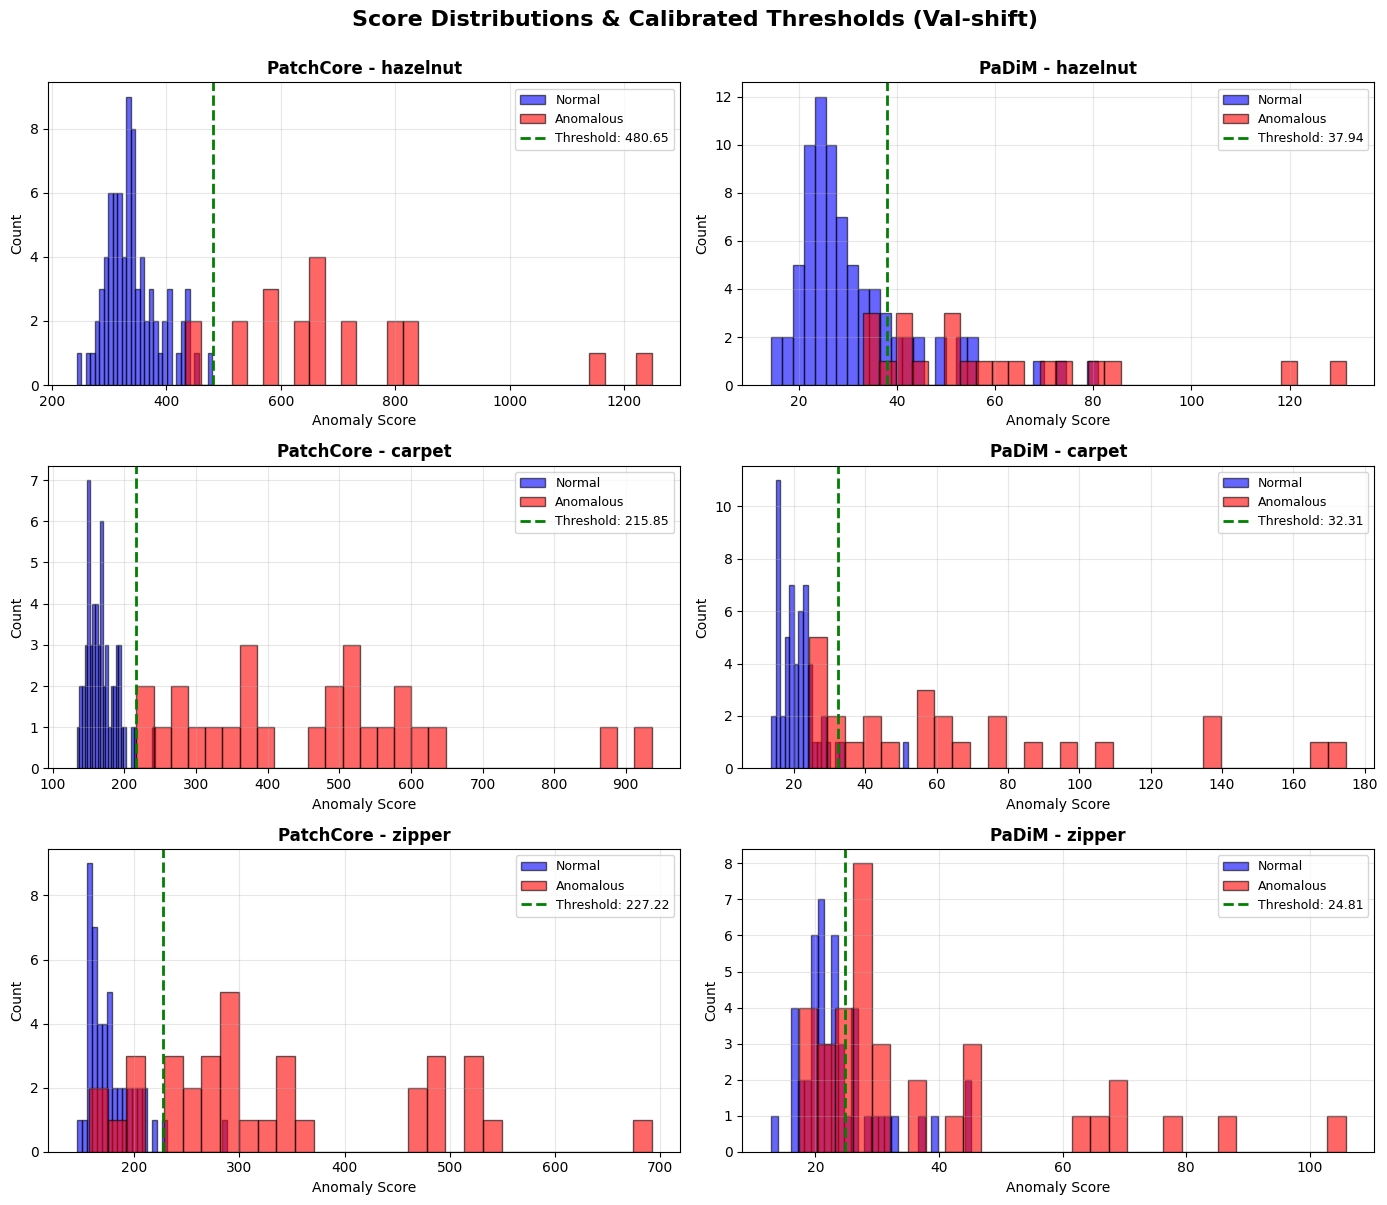

In [19]:
# Prepare calibration data from validation predictions
calibration_data = {
    'patchcore': {},
    'padim': {}
}

for class_name in CLASSES:
    # PatchCore
    calibration_data['patchcore'][class_name] = {
        'scores': np.array(patchcore_val_predictions_shift[class_name]['scores']),
        'labels': np.array(patchcore_val_predictions_shift[class_name]['labels']),
        'threshold': patchcore_calibrator_shift.get_threshold(class_name)
    }

    # PaDiM
    calibration_data['padim'][class_name] = {
        'scores': np.array(padim_val_predictions_shift[class_name]['scores']),
        'labels': np.array(padim_val_predictions_shift[class_name]['labels']),
        'threshold': padim_calibrator_shift.get_threshold(class_name)
    }

# Create visualization
fig, axes = plt.subplots(len(CLASSES), 2, figsize=(14, 4*len(CLASSES)))

# Handle single class case (axes would be 1D)
if len(CLASSES) == 1:
    axes = axes.reshape(1, -1)

for i, class_name in enumerate(CLASSES):
    # PatchCore
    ax1 = axes[i, 0]
    pc_data = calibration_data['patchcore'][class_name]
    normal_scores = pc_data['scores'][pc_data['labels'] == 0]
    anomalous_scores = pc_data['scores'][pc_data['labels'] == 1]

    ax1.hist(normal_scores, bins=30, alpha=0.6, label='Normal', color='blue', edgecolor='black')
    ax1.hist(anomalous_scores, bins=30, alpha=0.6, label='Anomalous', color='red', edgecolor='black')
    ax1.axvline(pc_data['threshold'], color='green', linestyle='--', linewidth=2,
                label=f'Threshold: {pc_data["threshold"]:.2f}')
    ax1.set_title(f'PatchCore - {class_name}', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Anomaly Score', fontsize=10)
    ax1.set_ylabel('Count', fontsize=10)
    ax1.legend(loc='upper right', fontsize=9)
    ax1.grid(True, alpha=0.3)

    # PaDiM
    ax2 = axes[i, 1]
    pd_data = calibration_data['padim'][class_name]
    normal_scores = pd_data['scores'][pd_data['labels'] == 0]
    anomalous_scores = pd_data['scores'][pd_data['labels'] == 1]

    ax2.hist(normal_scores, bins=30, alpha=0.6, label='Normal', color='blue', edgecolor='black')
    ax2.hist(anomalous_scores, bins=30, alpha=0.6, label='Anomalous', color='red', edgecolor='black')
    ax2.axvline(pd_data['threshold'], color='green', linestyle='--', linewidth=2,
                label=f'Threshold: {pd_data["threshold"]:.2f}')
    ax2.set_title(f'PaDiM - {class_name}', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Anomaly Score', fontsize=10)
    ax2.set_ylabel('Count', fontsize=10)
    ax2.legend(loc='upper right', fontsize=9)
    ax2.grid(True, alpha=0.3)

plt.suptitle('Score Distributions & Calibrated Thresholds (Val-shift)',
             fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()

# Save figure
save_path = VIZ_DIR / 'score_distributions_shift_full_adaptation.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"\n[SAVED] {save_path}")
plt.show()

## 17. Visualize ROC Curves

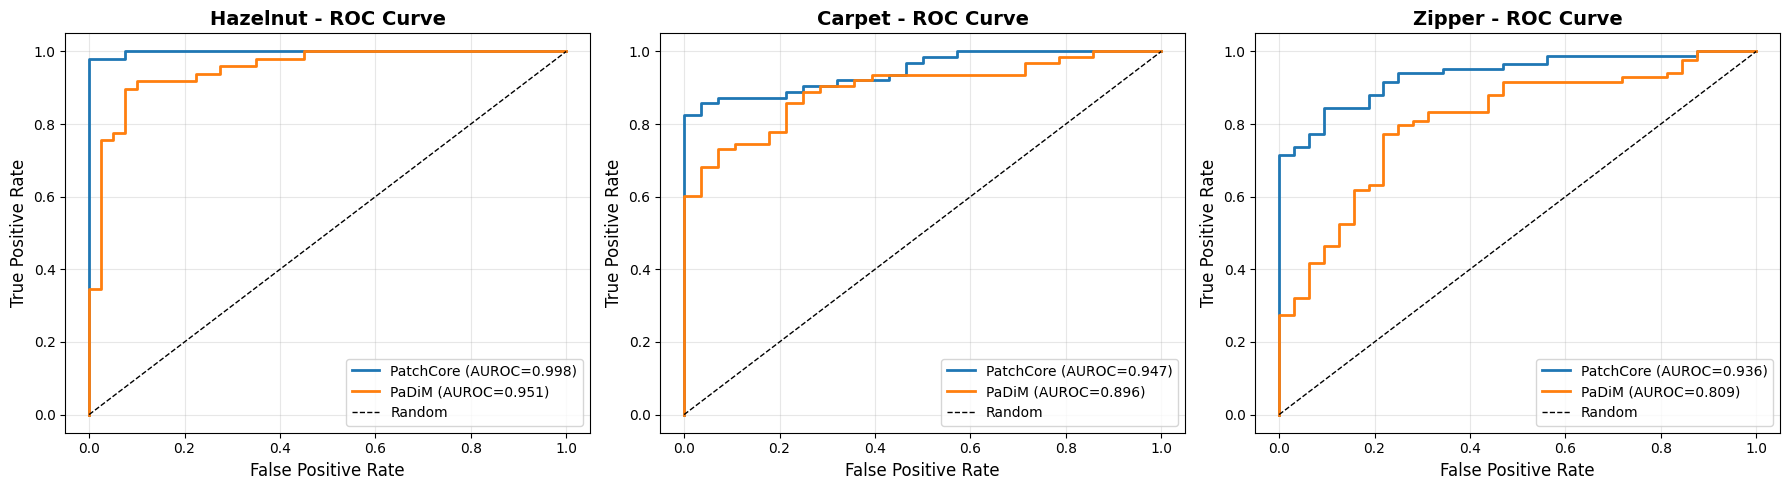

 ROC curves saved to: /content/Detection-of-Anomalies-with-Localization/outputs/visualizations/shifted_full_adaptation/roc_curves_shift_full_adaptation.png


In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, class_name in enumerate(CLASSES):
    ax = axes[idx]

    # PatchCore
    pc_scores = np.array(patchcore_results_shift[class_name]['predictions']['scores'])
    pc_labels = np.array(patchcore_results_shift[class_name]['predictions']['labels'])
    pc_fpr, pc_tpr, _ = compute_roc_curve(pc_labels, pc_scores)
    pc_auroc = patchcore_results_shift[class_name]['image_metrics']['auroc']

    # PaDiM
    pd_scores = np.array(padim_results_shift[class_name]['predictions']['scores'])
    pd_labels = np.array(padim_results_shift[class_name]['predictions']['labels'])
    pd_fpr, pd_tpr, _ = compute_roc_curve(pd_labels, pd_scores)
    pd_auroc = padim_results_shift[class_name]['image_metrics']['auroc']

    # Plot
    ax.plot(pc_fpr, pc_tpr, label=f'PatchCore (AUROC={pc_auroc:.3f})', linewidth=2)
    ax.plot(pd_fpr, pd_tpr, label=f'PaDiM (AUROC={pd_auroc:.3f})', linewidth=2)
    ax.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)

    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(f'{class_name.capitalize()} - ROC Curve', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(alpha=0.3)

plt.tight_layout()
roc_path = VIZ_DIR / 'roc_curves_shift_full_adaptation.png'
plt.savefig(roc_path, dpi=300, bbox_inches='tight')
plt.show()
print(f" ROC curves saved to: {roc_path}")

## 18. Visualize Precision-Recall Curves

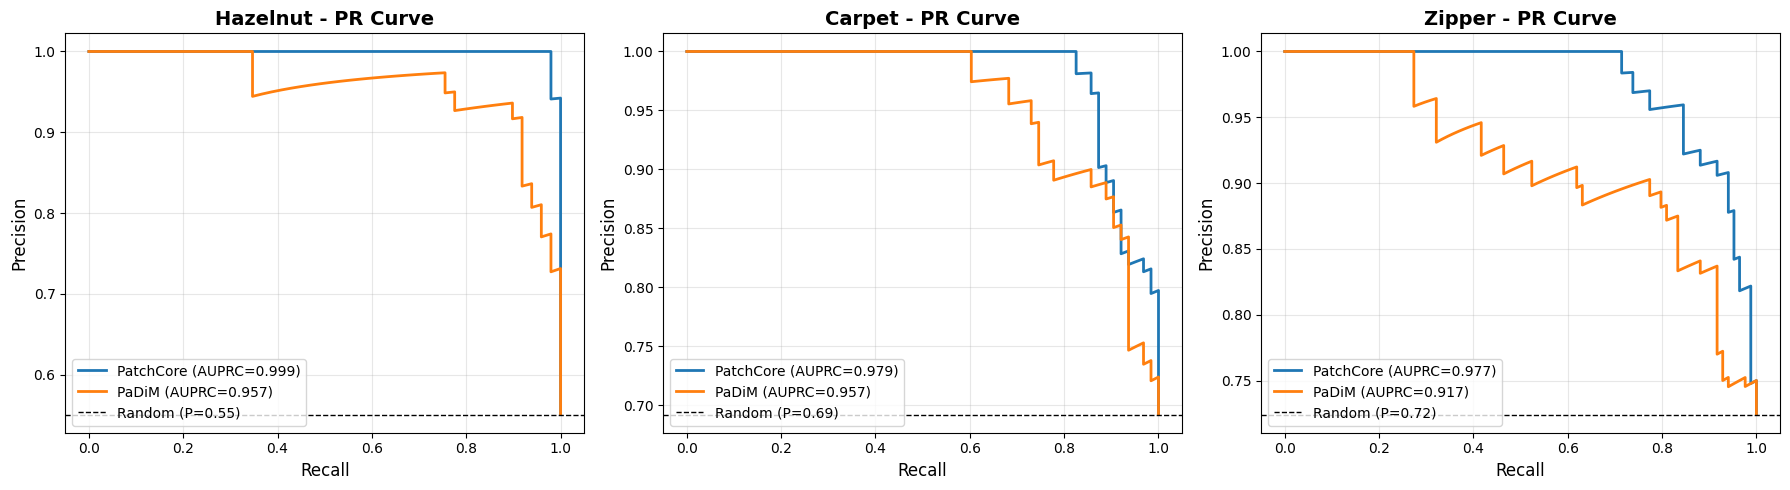

PR curves saved to: /content/Detection-of-Anomalies-with-Localization/outputs/visualizations/shifted_full_adaptation/pr_curves_shift_full_adaptation.png


In [21]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, class_name in enumerate(CLASSES):
    ax = axes[idx]

    # PatchCore
    pc_scores = np.array(patchcore_results_shift[class_name]['predictions']['scores'])
    pc_labels = np.array(patchcore_results_shift[class_name]['predictions']['labels'])
    pc_precision, pc_recall, _ = compute_pr_curve(pc_labels, pc_scores)
    pc_auprc = patchcore_results_shift[class_name]['image_metrics']['auprc']

    # PaDiM
    pd_scores = np.array(padim_results_shift[class_name]['predictions']['scores'])
    pd_labels = np.array(padim_results_shift[class_name]['predictions']['labels'])
    pd_precision, pd_recall, _ = compute_pr_curve(pd_labels, pd_scores)
    pd_auprc = padim_results_shift[class_name]['image_metrics']['auprc']

    # Plot
    ax.plot(pc_recall, pc_precision, label=f'PatchCore (AUPRC={pc_auprc:.3f})', linewidth=2)
    ax.plot(pd_recall, pd_precision, label=f'PaDiM (AUPRC={pd_auprc:.3f})', linewidth=2)

    # Random baseline (proportion of anomalies)
    baseline = sum(pc_labels) / len(pc_labels)
    ax.axhline(y=baseline, color='k', linestyle='--', label=f'Random (P={baseline:.2f})', linewidth=1)

    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title(f'{class_name.capitalize()} - PR Curve', fontsize=14, fontweight='bold')
    ax.legend(loc='lower left')
    ax.grid(alpha=0.3)

plt.tight_layout()
pr_path = VIZ_DIR / 'pr_curves_shift_full_adaptation.png'
plt.savefig(pr_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"PR curves saved to: {pr_path}")

## 19. Visualize Sample Predictions with Heatmaps

/tmp/ipython-input-1008209295.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pd_score = float(pd_score_raw[0])


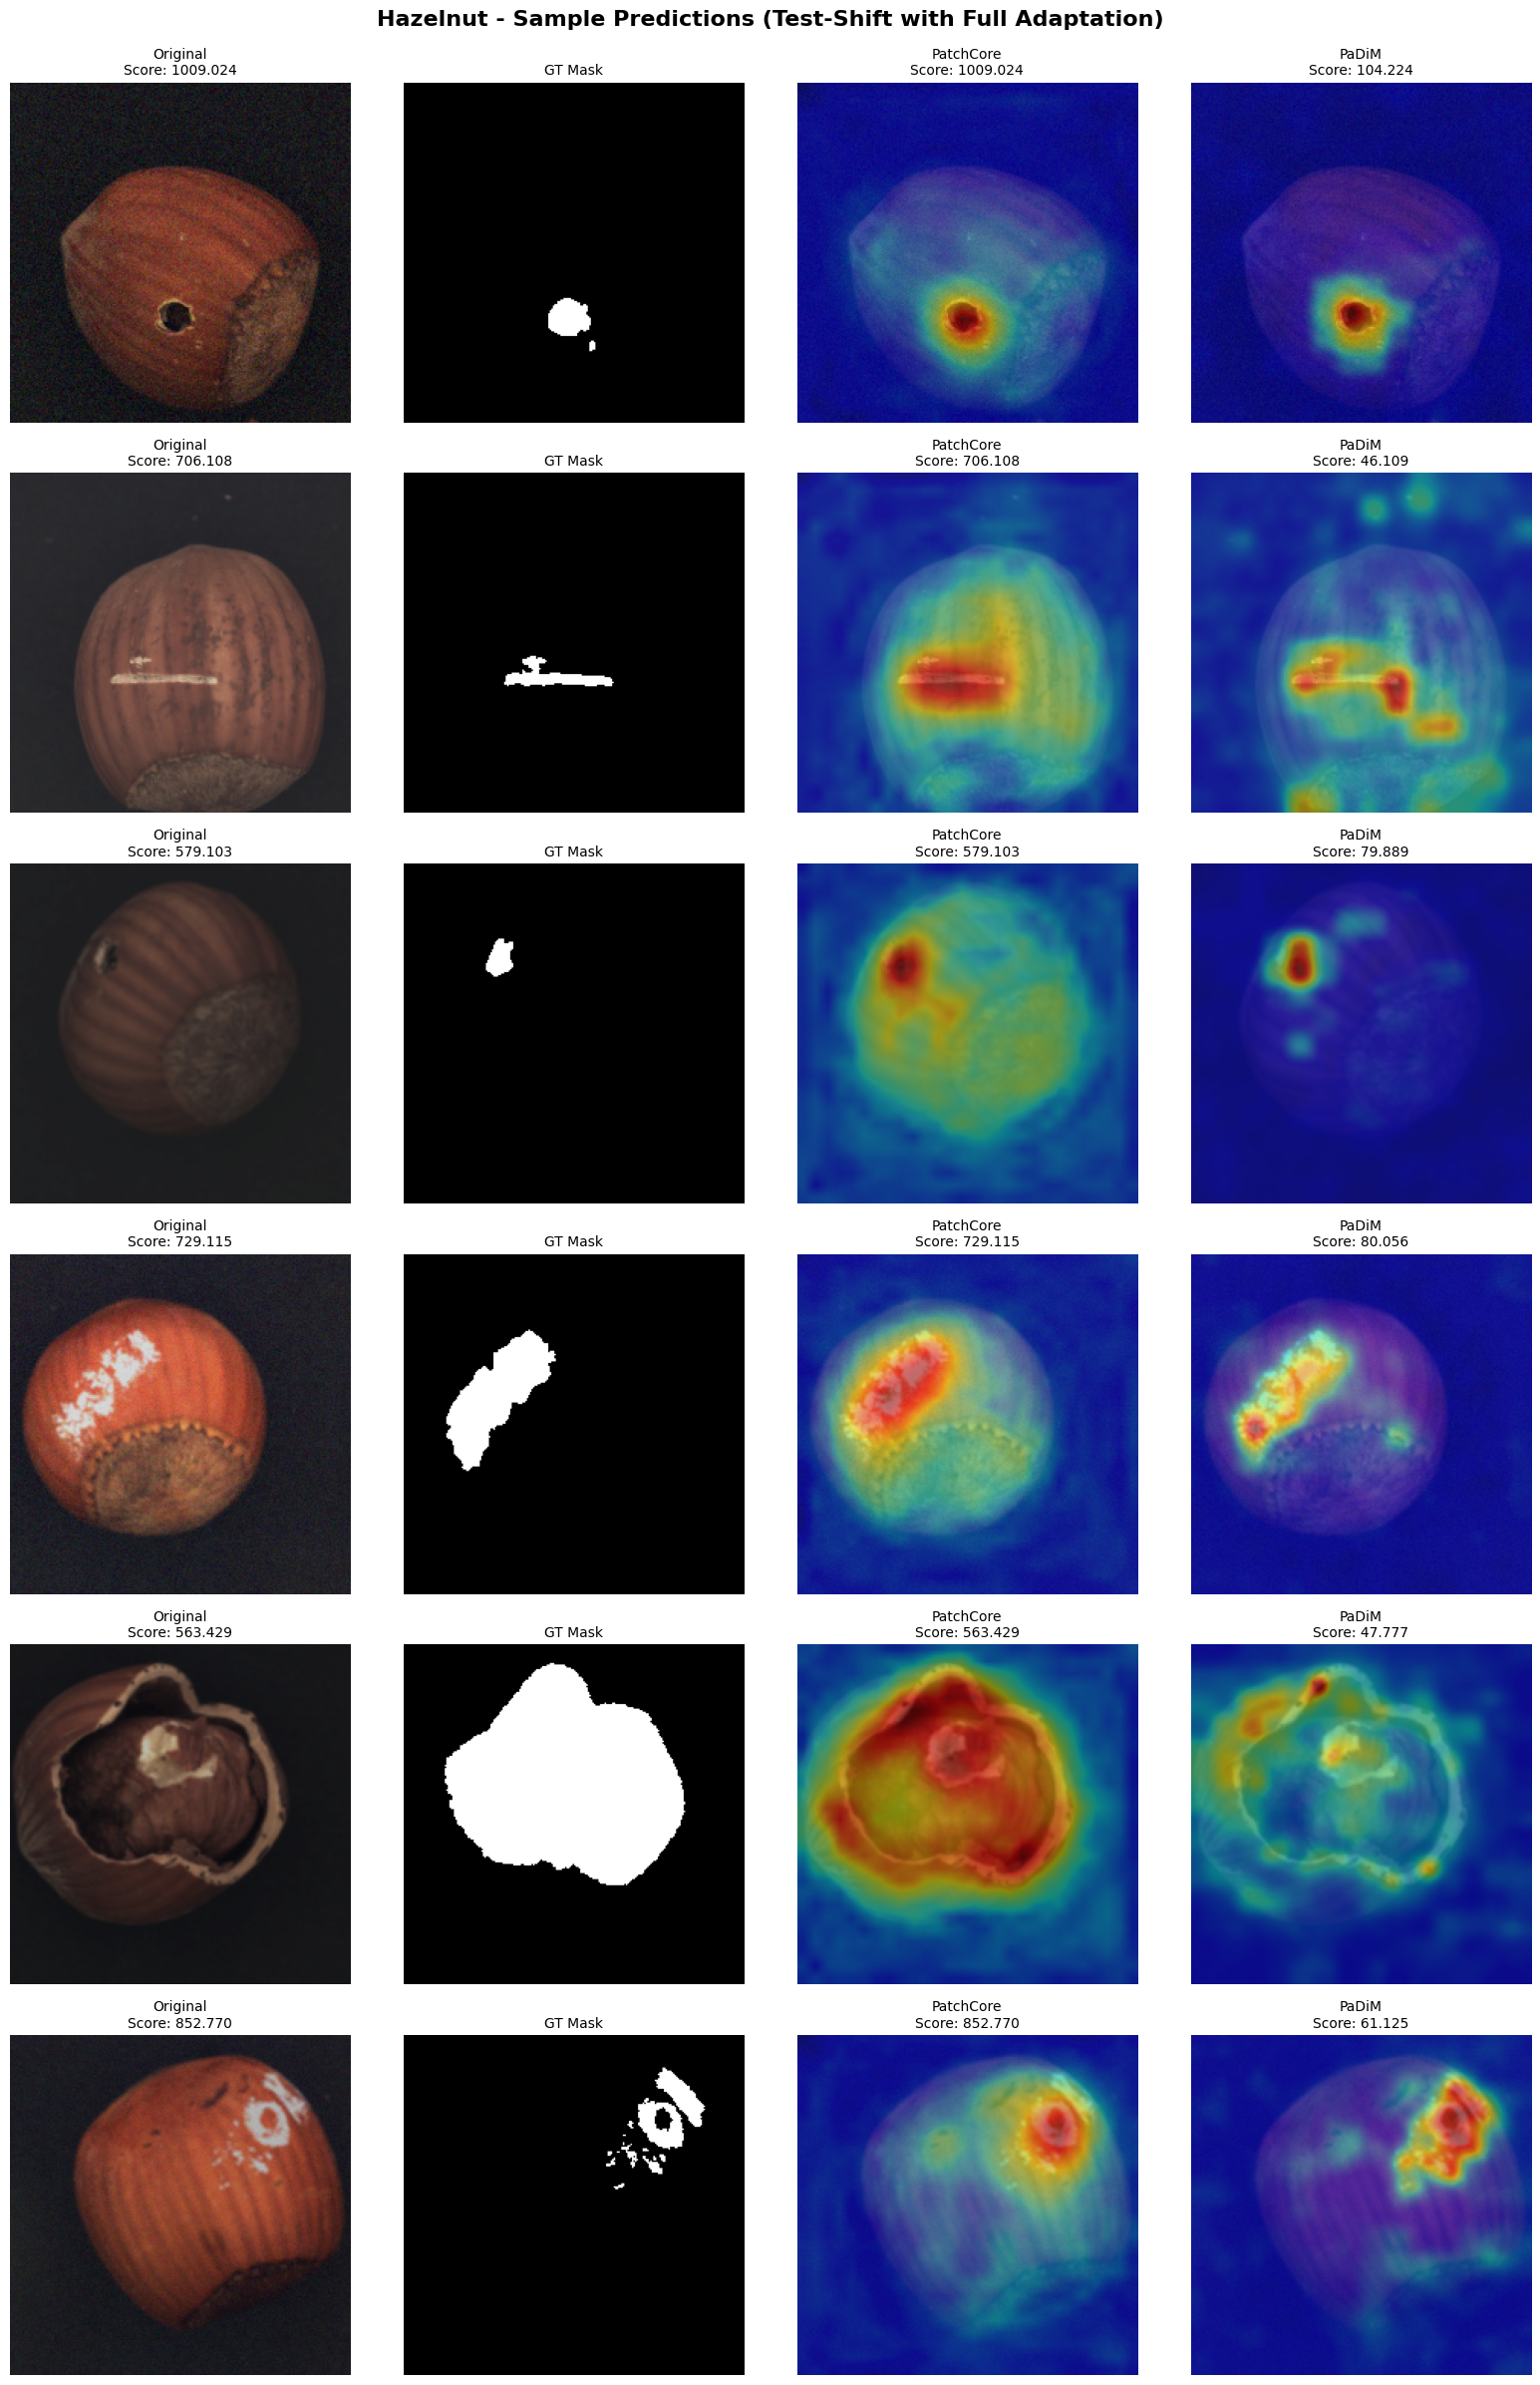

 Sample predictions saved to: /content/Detection-of-Anomalies-with-Localization/outputs/visualizations/shifted_full_adaptation/sample_predictions_hazelnut_shift_full_adaptation.png


In [22]:
from src.utils.utils import denormalize_image

# Select one class for detailed visualization
class_name = 'hazelnut'  # Change to visualize other classes

# Load test-shift data for this class
test_split = shifted_splits[class_name]['test']
test_dataset = MVTecDataset.from_split(
    test_split,
    transform=transform,
    phase='test'
)

# Get anomalous samples
anomalous_indices = [i for i, l in enumerate(test_dataset.labels) if l == 1]

# Select 6 random anomalous samples
np.random.seed(42)
sample_indices = np.random.choice(anomalous_indices, min(6, len(anomalous_indices)), replace=False)

# Get predictions
patchcore_model = patchcore_models_shift[class_name]
padim_model = padim_models_shift[class_name]

fig, axes = plt.subplots(6, 4, figsize=(16, 24))

for row_idx, sample_idx in enumerate(sample_indices):
    image, mask, label, path = test_dataset[sample_idx]

    # PatchCore prediction
    with torch.no_grad():
        pc_score_raw, pc_heatmap_raw = patchcore_model.predict(image.unsqueeze(0).to(DEVICE), return_heatmaps=True)
        pc_score = float(pc_score_raw[0])
        pc_heatmap = pc_heatmap_raw[0]

    # PaDiM prediction
    with torch.no_grad():
        pd_score_raw, pd_heatmap_raw = padim_model.predict(image.unsqueeze(0).to(DEVICE))
        pd_score = float(pd_score_raw[0])
        pd_heatmap = pd_heatmap_raw[0]

    # Denormalize image
    img_vis = denormalize_image(image, config.dataset.normalize.mean, config.dataset.normalize.std)

    # Plot
    # Column 1: Original Image
    axes[row_idx, 0].imshow(img_vis)
    axes[row_idx, 0].set_title(f'Original\nScore: {pc_score:.3f}', fontsize=10)
    axes[row_idx, 0].axis('off')

    # Column 2: Ground Truth Mask
    if mask is not None:
        mask_np = mask.squeeze().cpu().numpy() if isinstance(mask, torch.Tensor) else np.array(mask).squeeze()
        axes[row_idx, 1].imshow(mask_np, cmap='gray')
        axes[row_idx, 1].set_title('GT Mask', fontsize=10)
    else:
        axes[row_idx, 1].text(0.5, 0.5, 'No Mask', ha='center', va='center', fontsize=12)
    axes[row_idx, 1].axis('off')

    # Column 3: PatchCore Heatmap
    axes[row_idx, 2].imshow(img_vis)
    axes[row_idx, 2].imshow(pc_heatmap, cmap='jet', alpha=0.5, vmin=0, vmax=pc_heatmap.max())
    axes[row_idx, 2].set_title(f'PatchCore\nScore: {pc_score:.3f}', fontsize=10)
    axes[row_idx, 2].axis('off')

    # Column 4: PaDiM Heatmap
    axes[row_idx, 3].imshow(img_vis)
    axes[row_idx, 3].imshow(pd_heatmap, cmap='jet', alpha=0.5, vmin=0, vmax=pd_heatmap.max())
    axes[row_idx, 3].set_title(f'PaDiM\nScore: {pd_score:.3f}', fontsize=10)
    axes[row_idx, 3].axis('off')

plt.suptitle(f'{class_name.capitalize()} - Sample Predictions (Test-Shift with Full Adaptation)',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
heatmap_path = VIZ_DIR / f'sample_predictions_{class_name}_shift_full_adaptation.png'
plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')
plt.show()
print(f" Sample predictions saved to: {heatmap_path}")

### Confusion Matrices

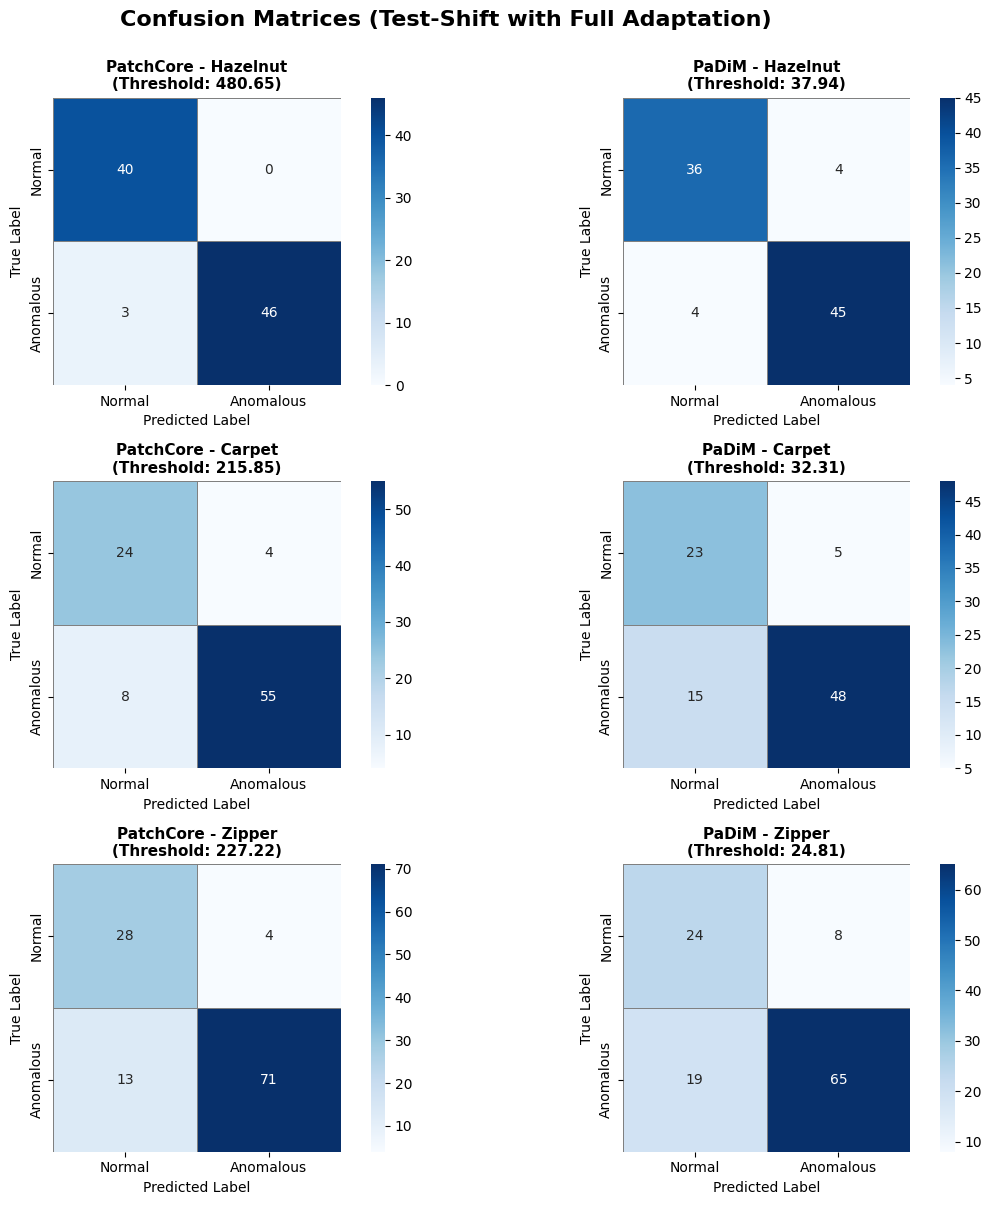

Confusion matrices saved to: /content/Detection-of-Anomalies-with-Localization/outputs/visualizations/shifted_full_adaptation/confusion_matrices_shift_full_adaptation.png

CONFUSION MATRIX STATISTICS

HAZELNUT:
  PatchCore (Threshold: 480.65):
    TN: 40, FP: 0, FN: 3, TP: 46
    Specificity: 1.0000
    Sensitivity (Recall): 0.9388
  PaDiM (Threshold: 37.94):
    TN: 36, FP: 4, FN: 4, TP: 45
    Specificity: 0.9000
    Sensitivity (Recall): 0.9184

CARPET:
  PatchCore (Threshold: 215.85):
    TN: 24, FP: 4, FN: 8, TP: 55
    Specificity: 0.8571
    Sensitivity (Recall): 0.8730
  PaDiM (Threshold: 32.31):
    TN: 23, FP: 5, FN: 15, TP: 48
    Specificity: 0.8214
    Sensitivity (Recall): 0.7619

ZIPPER:
  PatchCore (Threshold: 227.22):
    TN: 28, FP: 4, FN: 13, TP: 71
    Specificity: 0.8750
    Sensitivity (Recall): 0.8452
  PaDiM (Threshold: 24.81):
    TN: 24, FP: 8, FN: 19, TP: 65
    Specificity: 0.7500
    Sensitivity (Recall): 0.7738


In [23]:
fig, axes = plt.subplots(len(CLASSES), 2, figsize=(12, 4*len(CLASSES)))

# Handle single class case
if len(CLASSES) == 1:
    axes = axes.reshape(1, -1)

for i, class_name in enumerate(CLASSES):
    # PatchCore confusion matrix
    ax_pc = axes[i, 0]
    pc_scores = np.array(patchcore_results_shift[class_name]['predictions']['scores'])
    pc_labels = np.array(patchcore_results_shift[class_name]['predictions']['labels'])
    pc_threshold = patchcore_results_shift[class_name]['threshold']

    cm_pc = compute_confusion_matrix(pc_labels, pc_scores, pc_threshold)

    sns.heatmap(cm_pc, annot=True, fmt='d', cmap='Blues', ax=ax_pc,
                xticklabels=['Normal', 'Anomalous'],
                yticklabels=['Normal', 'Anomalous'],
                cbar=True, square=True, linewidths=0.5, linecolor='gray')
    ax_pc.set_xlabel('Predicted Label', fontsize=10)
    ax_pc.set_ylabel('True Label', fontsize=10)
    ax_pc.set_title(f'PatchCore - {class_name.capitalize()}\n(Threshold: {pc_threshold:.2f})',
                    fontsize=11, fontweight='bold')

    # PaDiM confusion matrix
    ax_pd = axes[i, 1]
    pd_scores = np.array(padim_results_shift[class_name]['predictions']['scores'])
    pd_labels = np.array(padim_results_shift[class_name]['predictions']['labels'])
    pd_threshold = padim_results_shift[class_name]['threshold']

    cm_pd = compute_confusion_matrix(pd_labels, pd_scores, pd_threshold)

    sns.heatmap(cm_pd, annot=True, fmt='d', cmap='Blues', ax=ax_pd,
                xticklabels=['Normal', 'Anomalous'],
                yticklabels=['Normal', 'Anomalous'],
                cbar=True, square=True, linewidths=0.5, linecolor='gray')
    ax_pd.set_xlabel('Predicted Label', fontsize=10)
    ax_pd.set_ylabel('True Label', fontsize=10)
    ax_pd.set_title(f'PaDiM - {class_name.capitalize()}\n(Threshold: {pd_threshold:.2f})',
                    fontsize=11, fontweight='bold')

plt.suptitle('Confusion Matrices (Test-Shift with Full Adaptation)',
             fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()

# Save figure
cm_path = VIZ_DIR / 'confusion_matrices_shift_full_adaptation.png'
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Confusion matrices saved to: {cm_path}")

# Print detailed statistics
print("\n" + "="*70)
print("CONFUSION MATRIX STATISTICS")
print("="*70)

for class_name in CLASSES:
    print(f"\n{class_name.upper()}:")

    # PatchCore
    pc_scores = np.array(patchcore_results_shift[class_name]['predictions']['scores'])
    pc_labels = np.array(patchcore_results_shift[class_name]['predictions']['labels'])
    pc_threshold = patchcore_results_shift[class_name]['threshold']
    cm_pc = compute_confusion_matrix(pc_labels, pc_scores, pc_threshold)

    tn_pc, fp_pc, fn_pc, tp_pc = cm_pc.ravel()

    print(f"  PatchCore (Threshold: {pc_threshold:.2f}):")
    print(f"    TN: {tn_pc}, FP: {fp_pc}, FN: {fn_pc}, TP: {tp_pc}")
    print(f"    Specificity: {tn_pc/(tn_pc+fp_pc):.4f}")
    print(f"    Sensitivity (Recall): {tp_pc/(tp_pc+fn_pc):.4f}")

    # PaDiM
    pd_scores = np.array(padim_results_shift[class_name]['predictions']['scores'])
    pd_labels = np.array(padim_results_shift[class_name]['predictions']['labels'])
    pd_threshold = padim_results_shift[class_name]['threshold']
    cm_pd = compute_confusion_matrix(pd_labels, pd_scores, pd_threshold)

    tn_pd, fp_pd, fn_pd, tp_pd = cm_pd.ravel()

    print(f"  PaDiM (Threshold: {pd_threshold:.2f}):")
    print(f"    TN: {tn_pd}, FP: {fp_pd}, FN: {fn_pd}, TP: {tp_pd}")
    print(f"    Specificity: {tn_pd/(tn_pd+fp_pd):.4f}")
    print(f"    Sensitivity (Recall): {tp_pd/(tp_pd+fn_pd):.4f}")

print("="*70)

## 20. Final Summary

FULL SHIFT ADAPTATION COMPLETE

**Key Achievements**:
- Re-trained PatchCore on Train-shift (all classes)
- Re-trained PaDiM on Train-shift (all classes)
- Calibrated thresholds on Val-shift (F1-optimal)
- Evaluated on Test-shift with adapted models


FILES GENERATED

- **Models** (`outputs/models/`)
    - `patchcore_<class>_shift.npy` — PatchCore memory bank
    - `patchcore_<class>_shift_config.pth` — PatchCore config
    - `padim_<class>_shift.pt` — PaDiM model (Gaussian distributions)
- **Results & Metrics** (`outputs/results/`)
    - `patchcore_shift_full_adaptation_results.json` — Complete PatchCore results
    - `padim_shift_full_adaptation_results.json` — Complete PaDiM results
    - `shift_full_adaptation_results_summary.csv` — Summary table with macro-averages
    - `patchcore_shift_training_stats.csv` — Training statistics for PatchCore
    - `padim_shift_training_stats.csv` — Training statistics for PaDiM
- **Calibrated Thresholds** (`outputs/thresholds/`)
    - `patchcore_shift_thresholds.json` — F1-optimal thresholds on Val-shift
    - `padim_shift_thresholds.json` — F1-optimal thresholds on Val-shift
- **Visualizations** (`outputs/visualizations/shifted_full_adaptation/`)
    - `score_distributions_shift_full_adaptation.png` — Score distributions with thresholds
    - `roc_curves_shift_full_adaptation.png` — ROC curves comparing PatchCore vs PaDiM
    - `pr_curves_shift_full_adaptation.png` — Precision-Recall curves
    - `confusion_matrices_shift_full_adaptation.png` — Confusion matrices (TN/FP/FN/TP)
    - `sample_predictions_<class>_shift_full_adaptation.png` — Heatmap overlays

In [24]:
import shutil

# Create destination folder in Drive
DRIVE_ROOT = Path('/content/drive/MyDrive/anomaly_detection_project')
PHASE7_OUTPUTS = DRIVE_ROOT / '09_full_shift_adaptation_outputs'
PHASE7_OUTPUTS.mkdir(parents=True, exist_ok=True)

print("\n" + "="*70)
print("COPYING FILES TO GOOGLE DRIVE")
print("="*70)
print(f"\nDestination: {PHASE7_OUTPUTS}")

# List of all generated files
generated_files = []

# Models
print("\n Copying models...")
for class_name in CLASSES:
    model_files = [
        MODELS_DIR / f'patchcore_{class_name}_shift.npy',
        MODELS_DIR / f'patchcore_{class_name}_shift_config.pth',
        MODELS_DIR / f'padim_{class_name}_shift.pt'
    ]
    generated_files.extend(model_files)

# Results
print(" Copying results...")
result_files = [
    RESULTS_DIR / 'patchcore_shift_full_adaptation_results.json',
    RESULTS_DIR / 'padim_shift_full_adaptation_results.json',
    RESULTS_DIR / 'shift_full_adaptation_results_summary.csv',
    RESULTS_DIR / 'patchcore_shift_training_stats.csv',
    RESULTS_DIR / 'padim_shift_training_stats.csv'
]
generated_files.extend(result_files)

# Thresholds
print(" Copying thresholds...")
threshold_files = [
    THRESHOLDS_DIR / 'patchcore_shift_thresholds.json',
    THRESHOLDS_DIR / 'padim_shift_thresholds.json'
]
generated_files.extend(threshold_files)

# Visualizations
print(" Copying visualizations...")
viz_files = [
    VIZ_DIR / 'score_distributions_shift_full_adaptation.png',
    VIZ_DIR / 'roc_curves_shift_full_adaptation.png',
    VIZ_DIR / 'pr_curves_shift_full_adaptation.png',
    VIZ_DIR / 'confusion_matrices_shift_full_adaptation.png'  # ← AGGIUNTO
]
for class_name in CLASSES:
    viz_files.append(VIZ_DIR / f'sample_predictions_{class_name}_shift_full_adaptation.png')
generated_files.extend(viz_files)

# Copy all files
copied_count = 0
missing_count = 0

for src_path in generated_files:
    if src_path.exists():
        # Preserve directory structure
        if 'models' in str(src_path):
            dst_dir = PHASE7_OUTPUTS / 'models'
        elif 'results' in str(src_path):
            dst_dir = PHASE7_OUTPUTS / 'results'
        elif 'thresholds' in str(src_path):
            dst_dir = PHASE7_OUTPUTS / 'thresholds'
        elif 'visualizations' in str(src_path):
            dst_dir = PHASE7_OUTPUTS / 'visualizations'
        else:
            dst_dir = PHASE7_OUTPUTS

        dst_dir.mkdir(parents=True, exist_ok=True)
        dst_path = dst_dir / src_path.name

        shutil.copy2(src_path, dst_path)
        print(f"  [OK] {src_path.name}")
        copied_count += 1
    else:
        print(f"   [MISSING] {src_path.name}")
        missing_count += 1

print("\n" + "="*70)
print(f"Copy complete: {copied_count} files copied, {missing_count} missing")
print(f" All results saved to: {PHASE7_OUTPUTS}")
print("="*70)


COPYING FILES TO GOOGLE DRIVE

Destination: /content/drive/MyDrive/anomaly_detection_project/09_full_shift_adaptation_outputs

 Copying models...
 Copying results...
 Copying thresholds...
 Copying visualizations...
  [OK] patchcore_hazelnut_shift.npy
  [OK] patchcore_hazelnut_shift_config.pth
  [OK] padim_hazelnut_shift.pt
  [OK] patchcore_carpet_shift.npy
  [OK] patchcore_carpet_shift_config.pth
  [OK] padim_carpet_shift.pt
  [OK] patchcore_zipper_shift.npy
  [OK] patchcore_zipper_shift_config.pth
  [OK] padim_zipper_shift.pt
  [OK] patchcore_shift_full_adaptation_results.json
  [OK] padim_shift_full_adaptation_results.json
  [OK] shift_full_adaptation_results_summary.csv
  [OK] patchcore_shift_training_stats.csv
  [OK] padim_shift_training_stats.csv
  [OK] patchcore_shift_thresholds.json
  [OK] padim_shift_thresholds.json
  [OK] score_distributions_shift_full_adaptation.png
  [OK] roc_curves_shift_full_adaptation.png
  [OK] pr_curves_shift_full_adaptation.png
  [OK] confusion_matri